# Часть 2: Тензорное разложение в Python

## Содержание
1. **Тензорное разложение**
2. **Реализация**
- Tensorly
- Numpy
3. **Результаты и сравнение**

### Тензорное разложение

Хотим модель $M$ которая апроксимирует $X \in \mathbb{R}^{I \times J \times K}$, так что $\textbf{a} \in \mathbb{R}^I $, $\textbf{b} \in \mathbb{R}^J$, и $\textbf{c} \in \mathbb{R}^K$ таким образом:

$$ X \approx M = \sum_{r=1}^{R} a_r \circ b_r \circ c_r$$

$$X \in \mathbb{R}^{I \times J \times K}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J, \textbf{c} \in \mathbb{R}^K$$

R - это **ранг**.В результате у нас есть 3 матрицы $A \in \mathbb{R}^{I \times R}$, $B \in \mathbb{R}^{J \times R}$, $C \in \mathbb{R}^{K \times R}$.

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/tensor-decomposition.png" alt="tensor-decomposition" width="800" align="center"/>
</center>

## Как найти A, B и C?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit

from sklearn.decomposition import FactorAnalysis, PCA
import tensorly as tl
from tensorly.decomposition import parafac
from tensortools.operations import khatri_rao
from tensor_utils import *

In [4]:
# 1. Depth (метры) глубина
# 3. CGR (Cumulative Gamma Ray) Кумулятивный гамма-луч
# 13. SW (водонасыщенность) Water Saturation

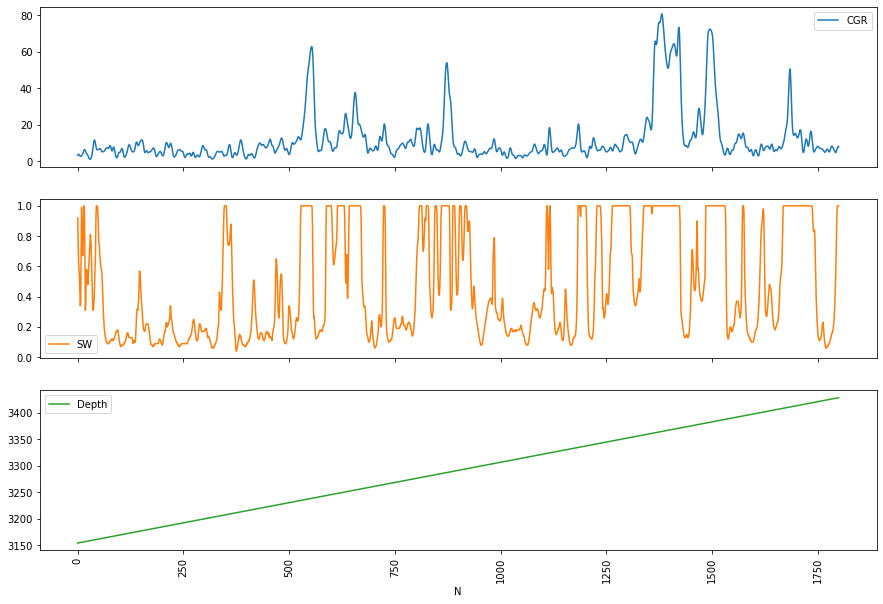

In [5]:
data = pd.read_excel("data/well_log.xlsx", sheet_name=0, nrows=1800)
plot_df = data[['CGR', 'SW', 'Depth']]
plot_df.plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [6]:
CGR = np.array(data.CGR).reshape(-1,3)
SW = np.array(data.SW).reshape(-1,3)
Dep = np.array(data.Depth).reshape(-1,3) # phie, cgr, DT

observed = np.einsum('ir,jr,vr', CGR, SW,  Dep)
print(observed.shape)

(600, 600, 600)


сохраним матрицы $A$, $B$, $C$ для последующего сравнения.

In [7]:
factors_actual = (normalize(CGR), normalize(SW), normalize(Dep))

## Реализация тензорного разложения с помощью библиотек

Вызовите функцию разложения и передайте тензор и ранг (количество факторов). В **Tensorly** функция называется "parafac", которая реализует каноническое полиадическое (CP) разложение с помощью  ALS метода. Существует история возникновения этого названия, но оно также известно как Каноническая декомпозиция (CANDECOMP), а также параллельная факторизация (PARAFAC).

Ниже приведен минимальный код для реализации CP разложения тензора в обеих библиотеках:
- Укажите тензор и ранг (количество факторов)
- Используйте функцию для разложения тензора
- Кроме того, мы можем восстановить оценку $M$, используя функцию "реконструировать", предусмотренную в скрипте.

In [8]:
X, rank = observed, 3

In [9]:
# TensorLy
weights, factors_tl = parafac(X, rank=rank)

In [10]:
# Восстановим исходный набор данных
M_tl = reconstruct(factors_tl)

In [ ]:
# Определяем ошибку восстановления
rec_error_tl = np.mean((X-M_tl)**2)

In [ ]:
# Визуализируем факторы полученные с помощью Tensorly
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

### Тензорное разложение через Numpy

В конечном счете, мы хотели бы свести к минимуму разницу между $ X $ и $ M $ (оценка модели, которая является приближением $ X $). Следовательно, мы можем сформулировать нашу функцию потерь как квадрат ошибки между $X$ и $M$:

$ M $ вычисляется с использованием трех матриц $A $, $ B $ и $ C$, все из которых мы не знаем. Один из способов найти их - оптимизировать для одной, одновременно исправляя две других. Как только мы оптимизируем одну из них, мы используем ее как фиксированную матрицу, оптимизируя для другой. И мы чередуем оптимизацию $A$, $B $ и $ C$ до сходимости или критерия остановки. Следовательно, мы собираемся записать нашу функцию потерь для каждой матрицы следующим образом:

In [556]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T#%%
factors_np = decompose_three_way(X, rank, verbose=False)

In [557]:
a, b, c = factors_np
factors = (normalize(a), normalize(b), normalize(c))

In [558]:
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

Сравнение между подходами при оценке $X$.

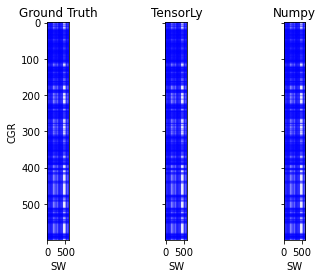

In [559]:
fig, axes = plt.subplots(1, 3, sharey=True)
tensors = [X, M_tl, M_np]
titles = ["Ground Truth", "TensorLy", "Numpy"]
trial_num = 50

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=10)
    ax.set_xlabel("SW")
    ax.set_title(title)
axes[0].set_ylabel("CGR");

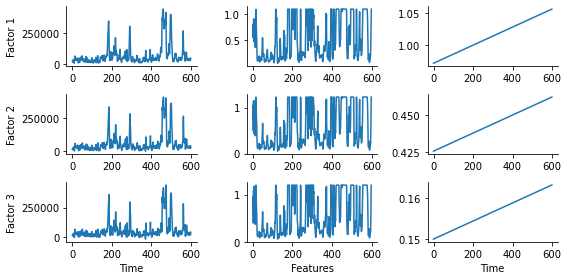

In [560]:
plot_factors(factors_np, d=3)

Оказывается, иногда факторы могут быть инвертированы. Однако, если один из них перевернут, то, безусловно, другой также должен быть перевернут. Следовательно, в зависимости от ожиданий и интерпретации, может потребоваться изменить некоторые факторы. Столбцы соответствуют факторам, а строки матрицам ($A$, $B$, $C$).

Нормализуем факторы, для того чтобы сравнить с ground true

In [561]:
factors = (normalize(a), normalize(b), normalize(c))

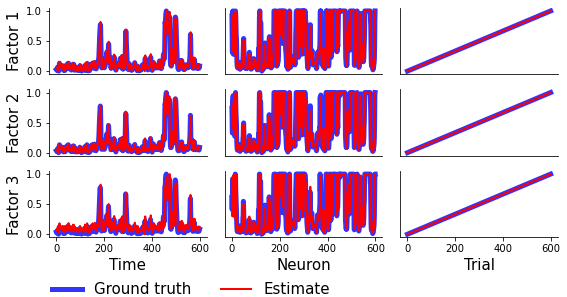

In [562]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[1, 0, 2], fig=fig);

### Сравнение подходов
#### Ошибка восстановления

In [563]:
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    weights, factors_tl = parafac(X, rank=rank, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

# # Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

In [564]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower left", fontsize=13);
plt.grid()

plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')